2020-01-17 12:29:55 INFO: Read cfg files: /home/jovyan/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/interface/spinnaker.cfg, /home/jovyan/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/spynnaker.cfg, /home/jovyan/.spynnaker.cfg
2020-01-17 12:29:55 INFO: Will search these locations for binaries: /home/jovyan/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/common_model_binaries : /home/jovyan/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/model_binaries


Detected PyNN version 0.9.4 and Neo version 0.6.1
['/home/jovyan/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/interface/spinnaker.cfg', '/home/jovyan/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/spynnaker.cfg', '/home/jovyan/.spynnaker.cfg']


2020-01-17 12:29:55 WARNING: /home/jovyan/01.RunningPyNNSimulations/Ishita2018-2019/reports has 24 old reports that have not been closed
2020-01-17 12:29:55 WARNING: /home/jovyan/01.RunningPyNNSimulations/Ishita2018-2019/application_generated_data_files has 24 old reports that have not been closed
2020-01-17 12:29:55 WARNING: A timestep was entered that has forced sPyNNaker to automatically slow the simulation down from real time by a factor of 10. To remove this automatic behaviour, please enter a timescaleFactor value in your .spynnaker.cfg
2020-01-17 12:29:55 INFO: Setting time scale factor to 10.
2020-01-17 12:29:55 INFO: Setting machine time step to 100 micro-seconds.
2020-01-17 12:29:55 WARNING: Formal PyNN specifies that v should be set using initial_values not cell_params
2020-01-17 12:29:55 WARNING: Formal PyNN specifies that u should be set using initial_values not cell_params
2020-01-17 12:29:55 WARNING: Formal PyNN specifies that v should be set using initial_values not cel

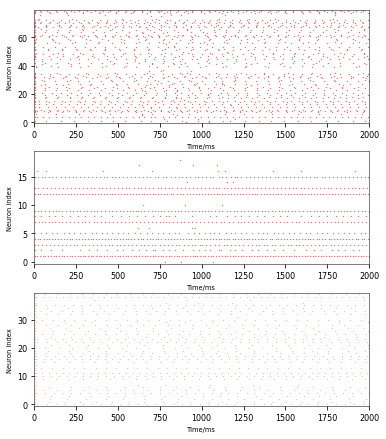

2020-01-17 12:31:28 WARNING: The weights from the synapses for IN_pop:0:19 on 0, 0, 11 saturated 1 times. If this causes issues you can increase the spikes_per_second and / or ring_buffer_sigma values located within the .spynnaker.cfg file.


10.656249999999998
24.125
12.475000000000005
--- 93.60396099090576 SECONDS ELAPSED ---
validating input isi used in the model: 333


In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


"""

LOGS:
18th January 2020
Basab: working with Ajay and trying to make the output random. Currently the TCR is highly synchronised.
the random v_init was set to positive values corrected that
the TRN was receiving current pulse input removed that
The current pulse is 10 - reduced this to 4
rate of the poisson input is set to 3 hz and applied between 600 and 1200 ms for a 2 sec simulation time
total number of neurons increased to 1400
-------------------------------------
Date: 15 November 2019

Version 2
1. Random IDC
2. Random v_init
3. One2One connection source2TCR/IN

--------------------------

Date: 29 October 2019

Implementing params according to Gunjan's model

---------------------------

Date: 24 October 2019

Changing neurons to IZK_cond and monitoring G_syn

---------------------------

Date: 3 August 2019

Add Poisson Spike Source to IN and TCR

---------------------------

Date: 2 August 2019

Implemented poisson distribution to i_offset for TCR, IN, TRN pop separately

---------------------------

Date: 24 July 2019

Implemented poisson distribution to i_offset for TCR pop only

---------------------------

Modifications mentioned above. Done by Ishita

Original Implementation:

Added code for plotting spiketrain and memb volt(all neurons- sluggish)- 27 March

Version uploaded on ModelDB October 2017.
Author:
Basabdatta Sen Bhattacharya, APT group, School of Computer Science,
University of Manchester, 2017.

If you are using the code,
please cite the original work on the model - details are:

B. Sen-Bhattacharya, T. Serrano-Gotarredona, L. Balassa, A. Bhattacharya,
A.B. Stokes, A. Rowley, I. Sugiarto, S.B. Furber,
"A spiking neural network model of the Lateral Geniculate Nucleus on the
SpiNNaker machine", Frontiers in Neuroscience, vol. 11 (454), 2017.

Free online access:
http://journal.frontiersin.org/article/10.3389/fnins.2017.00454/abstract

"""


# In[2]:


import spynnaker8 as p
import time
from spinn_front_end_common.utilities import globals_variables
from quantities import ms
import neo
import numpy as np

#for plotting
from pyNN.utility.plotting import Figure, Panel, Histogram
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

# for generating random numbers
from pyNN.random import RandomDistribution, NumpyRNG

start_time = time.time()
globals_variables.unset_simulator()


# In[3]:


''' Initialising Time and Frequency parameters'''

# total duration of simulation
TotalDuration = 2000.0

# # time-step of model equation solver
# time_resol = 0.1
# TimeInt = 1.0 / time_resol

# this is in ms.
Duration_Inp = 600.0

# 50 ms at both start and end are disregarded to avoid transients
Start_Inp = 600.0
End_Inp = int(Start_Inp + Duration_Inp)

# setting the input frequency of the spike train input
Rate_Inp = 3.0
Inp_isi = int(1000 / Rate_Inp)


# In[4]:


''' Initialising Model connectivity parameters'''
intra_pop_delay = RandomDistribution('uniform', (1,3), rng=NumpyRNG(seed=85520))
intra_nucleus_delay = RandomDistribution('uniform', (1,3), rng=NumpyRNG(seed=85521))
inter_nucleus_delay = RandomDistribution('uniform', (1,3), rng=NumpyRNG(seed=85522))
inter_pop_delay = RandomDistribution('uniform', (1,3), rng=NumpyRNG(seed=85523))
input_delay = inter_pop_delay

# # input_delay is the delay of the spike source hitting the neuronal populations
# # inter_pop_delay is the delay of spike communication between the different
# # populations of the model


# probabilities
p_trn2trn = 0.15
p_in2tcr = 0.1545#0.232
p_in2in = 0.236
p_tcr2trn = 0.35
p_trn2tcr = 0.1545#0.07
p_ret2tcr = 0.07
p_ret2in = 0.47

# weights
w_trn2trn = 0.01 #1
w_in2tcr = 0.1 #2
w_in2in = 0.1 #2
w_tcr2trn = 0.01 #2
w_trn2tcr = 0.01 #2
w_ret2tcr = 0.1 #1
w_ret2in = 0.1 #1


# In[5]:


''' Initialising Izhikevich spiking neuron model parameters.
We have used the conductance-based model here.'''

# Tonic mode parameters
tcr_a_tonic = 0.02
tcr_b_tonic = 0.2
tcr_c_tonic = -65.0
tcr_d_tonic = 6.0
tcr_v_init_tonic = RandomDistribution('uniform', (-63.0,-67.0), rng=NumpyRNG(seed=85520)) #-65.0

in_a_tonic = 0.1
in_b_tonic = 0.2
in_c_tonic = -65.0
in_d_tonic = 6.0
in_v_init_tonic = RandomDistribution('uniform', (-68.0,-72.0), rng=NumpyRNG(seed=85521)) #-70.0

trn_a_tonic = 0.02
trn_b_tonic = 0.2
trn_c_tonic = -65.0
trn_d_tonic = 6.0
trn_v_init_tonic = RandomDistribution('uniform', (-73.0,-77.0), rng=NumpyRNG(seed=85522)) #-75.0

tcr_a = tcr_a_tonic
tcr_b = tcr_b_tonic
tcr_c = tcr_c_tonic
tcr_d = tcr_d_tonic
tcr_v_init = tcr_v_init_tonic


in_a = in_a_tonic
in_b = in_b_tonic
in_c = in_c_tonic
in_d = in_d_tonic
in_v_init = in_v_init_tonic


trn_a = trn_a_tonic
trn_b = trn_b_tonic
trn_c = trn_c_tonic
trn_d = trn_d_tonic
trn_v_init = trn_v_init_tonic


tcr_u_init = -13.0 #tcr_b * tcr_v_init
in_u_init = -14.0 #in_b * in_v_init
trn_u_init = -15.0 #trn_b * trn_v_init

# a constant DC bias current; this is used here for testing the RS and FS
# characteristics of IZK neurons
current_Pulse = RandomDistribution('poisson', lambda_ = 5.0, rng=NumpyRNG(seed=85524)) #5 

# excitatory input time constant
tau_ex = 6.0 

# inhibitory input time constant
tau_inh = 4.0 

# reversal potentials
e_rev_ex = 0.0
e_rev_inh = -80.0


# In[6]:


'''Starting the SpiNNaker Simulator'''
p.setup(timestep=0.1, min_delay=1.0)
## set number of neurons per core to 50, for the spike source to avoid clogging
##p.set_number_of_neurons_per_core(p.SpikeSourceArray, 50)


# In[7]:


'''Defining each cell type as dictionary'''

# THALAMOCORTICAL RELAY CELLS (TCR)
TCR_cell_params = {'a': tcr_a_tonic, 'b': tcr_b, 'c': tcr_c, 'd': tcr_d,
                   'v': tcr_v_init, 'u': tcr_u_init,
                   'tau_syn_E': tau_ex, 'tau_syn_I': tau_inh,
                   'i_offset': current_Pulse, 'e_rev_E': e_rev_ex, 'e_rev_I': e_rev_inh
                   }

# THALAMIC INTERNEURONS (IN)
IN_cell_params = {'a': in_a, 'b': in_b, 'c': in_c, 'd': in_d,
                  'v': in_v_init, 'u': in_u_init,
                  'tau_syn_E': tau_ex, 'tau_syn_I': tau_inh,
                  'i_offset': current_Pulse, 'e_rev_E': e_rev_ex, 'e_rev_I': e_rev_inh
                  }

# THALAMIC RETICULAR NUCLEUS (TRN)
TRN_cell_params = {'a': trn_a, 'b': trn_b, 'c': trn_c, 'd': trn_d,
                   'v': trn_v_init, 'u': trn_u_init,
                   'tau_syn_E': tau_ex, 'tau_syn_I': tau_inh,
                   'i_offset': current_Pulse, 'e_rev_E': e_rev_ex, 'e_rev_I': e_rev_inh
                   }


# In[8]:


'''Creating populations of each cell type'''
scale_fact = 10
NumCellsTCR = 8*scale_fact
NumCellsIN = 2*scale_fact
NumCellsTRN = 4*scale_fact
TCR_pop = p.Population(
    NumCellsTCR, p.extra_models.Izhikevich_cond, TCR_cell_params, label='TCR_pop')
IN_pop = p.Population(
    NumCellsIN, p.extra_models.Izhikevich_cond, IN_cell_params, label='IN_pop')
TRN_pop = p.Population(
    NumCellsTRN, p.extra_models.Izhikevich_cond, TRN_cell_params, label='TRN_pop')


# In[9]:


''' Poisson spike train input defined of 80 for TCR'''

spike_source_TCR = p.Population(
    NumCellsTCR, p.SpikeSourcePoisson(
        rate=Rate_Inp,start=Start_Inp,duration=Duration_Inp),
    label='spike_source_TCR')

''' Poisson spike train input defined of 20 for IN'''

spike_source_IN = p.Population(
    NumCellsIN, p.SpikeSourcePoisson(
        rate=Rate_Inp,start=Start_Inp,duration=Duration_Inp),
    label='spike_source_IN')


'''Source to TCR population projections'''
Proj0 = p.Projection(
    spike_source_TCR, TCR_pop, p.OneToOneConnector(),
    p.StaticSynapse(weight=w_ret2tcr, delay=input_delay),
    receptor_type='excitatory')


'''Source2IN'''
Proj1 = p.Projection(
    spike_source_IN, IN_pop, p.OneToOneConnector(),
    p.StaticSynapse(weight=w_ret2in, delay=input_delay),
    receptor_type='excitatory')


'''TCR2TRN'''
Proj2 = p.Projection(
    TCR_pop, TRN_pop, p.FixedProbabilityConnector(p_connect=p_tcr2trn),
    p.StaticSynapse(weight=w_tcr2trn, delay=inter_nucleus_delay),
    receptor_type='excitatory')


'''TRN2TCR'''
Proj3 = p.Projection(
    TRN_pop, TCR_pop, p.FixedProbabilityConnector(p_connect=p_trn2tcr),
    p.StaticSynapse(weight=w_trn2tcr, delay=inter_nucleus_delay),
    receptor_type='inhibitory')


'''TRN2TRN'''
Proj4 = p.Projection(
    TRN_pop, TRN_pop, p.FixedProbabilityConnector(p_connect=p_trn2trn),
    p.StaticSynapse(weight=w_trn2trn, delay=intra_pop_delay),
    receptor_type='inhibitory')


'''IN2TCR'''
Proj5 = p.Projection(
    IN_pop, TCR_pop, p.FixedProbabilityConnector(p_connect=p_in2tcr),
    p.StaticSynapse(weight=w_in2tcr, delay=intra_nucleus_delay),
    receptor_type='inhibitory')


'''IN2IN'''
Proj6 = p.Projection(
    IN_pop, IN_pop, p.FixedProbabilityConnector(p_connect=p_in2in),
    p.StaticSynapse(weight=w_in2in, delay=intra_pop_delay),
    receptor_type='inhibitory')


''' Recording simulation data'''

# recording the spikes and voltage
spike_source_TCR.record("spikes")
spike_source_IN.record("spikes")
TCR_pop.record(("spikes", "v", "gsyn_exc", "gsyn_inh"))
IN_pop.record(("spikes", "v", "gsyn_exc", "gsyn_inh"))
TRN_pop.record(("spikes", "v", "gsyn_exc", "gsyn_inh"))

# TCR_pop.record("v")
# TRN_pop.record("v")
# IN_pop.record("v")


# In[10]:


p.run(TotalDuration)


# In[11]:


''' On simulation completion, extract the data off the spinnaker machine
memory'''


# extracting the spike time data
spikesourcepattern_TCR = spike_source_TCR.get_data("spikes")
spikesourcepattern_IN = spike_source_IN.get_data("spikes")
TCR_spikes = TCR_pop.get_data("spikes")
IN_spikes = IN_pop.get_data("spikes")
TRN_spikes = TRN_pop.get_data("spikes")

# extracting the membrane potential data (in millivolts)
TCR_membrane_volt = TCR_pop.get_data("v")
IN_membrane_volt = IN_pop.get_data("v")
TRN_membrane_volt = TRN_pop.get_data("v")

# print TCR_membrane_volt.segments[0].analogsignals
TCR_gsyn_e = TCR_pop.get_data("gsyn_exc")
IN_gsyn_e = IN_pop.get_data("gsyn_exc")
TRN_gsyn_e = TRN_pop.get_data("gsyn_exc")

TCR_gsyn_i = TCR_pop.get_data("gsyn_inh")
IN_gsyn_i = IN_pop.get_data("gsyn_inh")
TRN_gsyn_i = TRN_pop.get_data("gsyn_inh")


# In[12]:


# getting the input spike data and plotting it
v = TCR_membrane_volt.segments[0].analogsignals
spikes = TCR_spikes.segments[0].spiketrains

plt.rcParams.update({'font.size': 25})

Figure(
    # raster plot of the presynaptic neuron spike times
    Panel(spikes, xlabel="Time/ms", xticks=True, ylabel="TCR Spikes Plots for TotalDuration",
          yticks=True, markersize=0.5, xlim=(1, 2000), color = 'red'),
    Panel(IN_spikes.segments[0].spiketrains, xlabel="Time/ms", xticks=True, ylabel="IN Spikes Plots for TotalDuration",
          yticks=True, markersize=0.5, xlim=(1, 2000), color = 'red'),
    Panel(TRN_spikes.segments[0].spiketrains, xlabel="Time/ms", xticks=True, ylabel="TRN Spikes Plots for TotalDuration",
          yticks=True, markersize=0.2, xlim=(1, 2000), color = 'red'),
#     Panel(TCR_membrane_volt.segments[0].analogsignals[0], xlabel="Time/ms", ylabel="TCR Mem Volts for Neurons", xticks=True,
#           yticks=True, markersize=0.2, xlim=(500, 600)),
#     Panel(TRN_membrane_volt.segments[0].analogsignals[0], xlabel="Time/ms", ylabel="TRN Mem Volts for Neurons", xticks=True,
#           yticks=True, markersize=0.2, xlim=(500, 600)),
#     Panel(IN_membrane_volt.segments[0].analogsignals[0], xlabel="Time/ms", ylabel="IN Mem Volts for Neurons", xticks=True,
#           yticks=True, markersize=0.2, xlim=(500, 600)),
#     Panel(TCR_gsyn_e.segments[0].filter(name="gsyn_exc")[0], xlabel="Time/ms", ylabel="TCR Gsyn Exc for Neurons", xticks=True,
#           yticks=True, markersize=0.2, xlim=(500, 600)),
#     Panel(TRN_gsyn_e.segments[0].filter(name="gsyn_exc")[0], xlabel="Time/ms", ylabel="TRN Gsyn Exc for Neurons", xticks=True,
#           yticks=True, markersize=0.2, xlim=(500, 600)),
#     Panel(IN_gsyn_e.segments[0].filter(name="gsyn_exc")[0], xlabel="Time/ms", ylabel="IN Gsyn Exc for Neurons", xticks=True,
#           yticks=True, markersize=0.2, xlim=(500, 600)),
#     Panel(TCR_gsyn_i.segments[0].filter(name="gsyn_inh")[0], xlabel="Time/ms", ylabel="TCR Gsyn Inh for Neurons", xticks=True,
#           yticks=True, markersize=0.2, xlim=(500, 600)),
#     Panel(TRN_gsyn_i.segments[0].filter(name="gsyn_inh")[0], xlabel="Time/ms", ylabel="TRN Gsyn Inh for Neurons", xticks=True,
#           yticks=True, markersize=0.2, xlim=(500, 600)),
#     Panel(IN_gsyn_i.segments[0].filter(name="gsyn_inh")[0], xlabel="Time/ms", ylabel="IN Gsyn Inh for Neurons", xticks=True,
#           yticks=True, markersize=0.2, xlim=(500, 600)),
#     title='All Pops'
)
plt.show()


# In[13]:


''' Get mean firing rate '''

def get_mean_rate(numCells, population):
    firing_rate = []      # format = < neuron_id, rate (spikes/ms) >

    for index in range(0,numCells):
        rate = len(population.segments[0].spiketrains[index])/TotalDuration
        firing_rate.append(rate)
    
    return sum(firing_rate)/len(firing_rate)


# In[14]:


print(get_mean_rate(NumCellsTCR, TCR_spikes)*1000)
print(get_mean_rate(NumCellsIN, IN_spikes)*1000)
print(get_mean_rate(NumCellsTRN, TRN_spikes)*1000)


# In[15]:


''' Now release the SpiNNaker machine'''
p.end()

''' The user can now either save the data for further use, or plot this
using standard python tools'''

print("--- {} SECONDS ELAPSED ---".format(time.time() - start_time))
print("validating input isi used in the model: {}".format(Inp_isi))

